## Obtain the last trained model and predict scores for 10k random variants

In [66]:
from sklearn.externals import joblib
from kipoi_cadd.data import CaddDataset
from kipoi_cadd.utils import load_pickle, dump_to_pickle
from tqdm import tqdm
from math import log
from kipoi_cadd.utils import variant_id_string
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import cyvcf2
import numpy as np
import pandas as pd

In [12]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/"
kipoi_features_dir = "/s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/"
lmdb_dir = training_dir + "lmdb"
model_file = "/tmp/gin-train/62cdc2663f484ba9a9614dcd8283aad9/model.h5"
shuff_10k_file = training_dir + "ids_10k.pkl"
vars_to_compare = kipoi_features_dir + "vars_to_compare.vcf"
regions_txt = kipoi_features_dir + "regions.txt"
regions_output = kipoi_features_dir + "regions_output.vcf"

In [13]:
shuff_10k = load_pickle(shuff_10k_file)
shuff_10k.head()

17783505     1:49000062:A:['G']
7981343      8:98127146:T:['G']
33540028    12:47011284:N:['N']
9066941     10:25408052:A:['C']
1223325       2:5430769:G:['C']
dtype: object

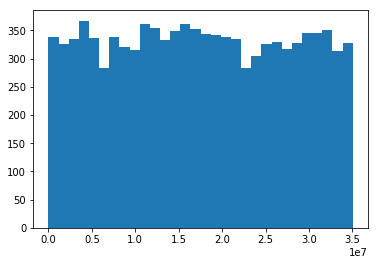

In [15]:
plt.hist(shuff_10k.index.values, bins=30);
plt.show()

In [17]:
def variants_to_basic_vcf(variants, output_file=None, n_lines=None):
    vcf_string = ""
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            vcf_string += var.CHROM + "\t" + var.POS + "\t" + var.ID + "\t" + var.REF + "\t" + var.ALT[0] + "\n"
        else:
            chrom, pos, ref, alt = var.split(":")
            vcf_string += chrom + "\t" + pos + "\tv" + str(i+1) + "\t" + ref + "\t" + alt.split("'")[1] + "\n"
        if n_lines is not None:
            if i >= n_lines: break

    if output_file is not None:
        with open(output_file, "w") as f:
            f.write(vcf_string)
        return None
    else:
        return vcf_string
    
def variants_to_basic_regions(variants, output_file=None, n_lines=None):
    region_df = {'CHROM': [], 'POS': [], 'REF': [], 'ALT': []}
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            # region_string += var.CHROM + "\t" + var.POS + "\n"
            region_df['CHROM'].append(int(var.CHROM))
            region_df['POS'].append(int(var.POS))
            region_df['REF'].append(var.REF)
            region_df['ALT'].append(var.ALT[0])
        else:
            chrom, pos, ref, alt = var.split(":")
            # region_string += chrom + "\t" + pos + "\n"
            if chrom == 'X' or chrom == 'Y':
                region_df['CHROM'].append(chrom)                
            else:
                region_df['CHROM'].append(int(chrom))
            region_df['POS'].append(int(pos))
            region_df['REF'].append(ref)
            region_df['ALT'].append(alt.split("'")[1])
    
        if n_lines is not None:
            if i >= n_lines: break
    
    df = pd.DataFrame(region_df)
    df.sort_values(by=['CHROM', 'POS'], inplace=True)
    # df['region'] = [':'.join([str(r.CHROM), str(r.POS) + "-" + str(r.POS), "1/" + r.ALT]) for r in df.itertuples()]
    # SNP
    # 5:140532-140532:1/C
    if output_file is not None:
        # df.region.to_csv(output_file, sep='\t', index=None, header=None)
        df.to_csv(output_file, sep='\t', index=None, header=None)
        return None
    else:
        return df

variants_to_basic_regions(shuff_10k, regions_txt)
# variants_to_basic_vcf(shuff_10k, vars_to_compare, n_lines=3)

### Load the model and the variants to be compared

In [18]:
clf = joblib.load(model_file)
ds = CaddDataset(lmdb_dir, shuff_10k_file)
X, y = ds.load_all(shuffle=False)

100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


In [19]:
# TODO: Why is this y.dtype = dtype('int64') ???
y.dtype

dtype('float64')

In [20]:
# Do the same process as the trainer
X_sparse = csr_matrix(X, shape=None, dtype=np.float32, copy=True)
X = X_sparse
y = y.astype(np.float32)
del X_sparse

In [21]:
y.dtype

dtype('float32')

In [23]:
y_pred_kipoi = clf.predict_proba(X)
y_pred_kipoi

array([[0.4649066 , 0.5350934 ],
       [0.39847899, 0.60152101],
       [0.44384684, 0.55615316],
       ...,
       [0.50736969, 0.49263031],
       [0.49401669, 0.50598331],
       [0.48529792, 0.51470208]])

## a. Use VEP to obtain CADD scores
Used this command:
`vep --input_file myVariants.vcf.gz --output_file myOutput.vcf --vcf --fields "CADD_PHRED,CADD_RAW" --cache --dir_cache /opt/modules/i12g/ensembl-vep/92/cachedir --assembly GRCh37 --offline --force_overwrite --plugin CADD,{path-to}/whole_genome_SNVs_1.3.tsv.gz,{path-to}/InDels_1.3.tsv.gz`

vep --input_file /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/vars_to_compare.vcf --output_file /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/vars_to_compare_output.vcf --vcf --fields "CADD_PHRED,CADD_RAW" --cache --dir_cache /opt/modules/i12g/ensembl-vep/92/cachedir --assembly GRCh37 --port 3337 --force_overwrite --plugin CADD,whole_genome_SNVs_1.3.tsv.gz,InDels_1.3.tsv.gz

vep --input_file /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/regions.txt --format region --output_file /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/regions_output.vcf --vcf --fields "CADD_PHRED,CADD_RAW" --cache --dir_cache /opt/modules/i12g/ensembl-vep/92/cachedir --assembly GRCh37 --port 3337 --force_overwrite --plugin CADD,whole_genome_SNVs_1.3.tsv.gz,InDels_1.3.tsv.gz

The INFO field presents itself as follows: `<key>=<data>[,data]`.

In [143]:
vcf_gz = "/s/databases/cadd/CADD_v1.3/test_output_1.3.vcf.gz"
test_vcf_gz = "/s/databases/cadd/CADD_v1.3/test.vcf"
my_vcf_output = kipoi_features_dir + "vars_to_compare_output.vcf"

In [32]:
from cyvcf2 import VCF

In [107]:
def get_cadd_scores_from_vcf(vcf_file):
    cadd_scores = {'CADD_PHRED': [], 'CADD_RAW': []}
    var_ids = []
    for var in VCF(vcf_file):
        scores = [(x.split('|')[0], x.split('|')[1]) for x in var.INFO.get('CSQ').split(',')]
        phred = float(scores[0][0]) if scores[0][0] != '' else None
        raw = float(scores[0][1]) if scores[0][1] != '' else None
        cadd_scores['CADD_PHRED'], cadd_scores['CADD_RAW'] = phred, raw
        var_ids.append(variant_id_string(var.CHROM, var.POS, var.REF, var.ALT))
    return pd.DataFrame(cadd_scores, index=var_ids)

In [151]:
my_scores = get_cadd_scores_from_vcf(my_vcf_output)
my_scores.head()

,CADD_PHRED,CADD_RAW
1:1088349:C:['T'],None,None
1:1106143:T:['C'],None,None
1:1967148:T:['C'],None,None
1:1840772:T:['G'],None,None


In [111]:
my_scores.shape

(10000, 2)

In [69]:
header_info = "Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|CADD_PHRED|CADD_RAW"
len(header_info.split("|"))

25

In [149]:
! head -10 {test_vcf_gz}

1	14673	rs11582131	G	C
1	14677	.	G	A
1	14699	rs11490464	C	G
1	14907	rs6682375	A	G
1	14930	rs6682385	A	G
1	15906	.	A	G
1	15922	rs80168857	A	G
1	15956	.	G	A
1	16949	rs708637	A	C
1	3519049	.	AC	A


In [146]:
! head -10 {regions_output}

##fileformat=VCFv4.1
##VEP="v92" time="2019-01-02 15:57:56" cache="/opt/modules/i12g/ensembl-vep/92/cachedir/homo_sapiens/92_GRCh37" db="homo_sapiens_core_92_37@ensembldb.ensembl.org" 1000genomes="phase3" COSMIC="81" ClinVar="201706" ESP="20141103" HGMD-PUBLIC="20164" assembly="GRCh37.p13" dbSNP="150" gencode="GENCODE 19" genebuild="2011-04" gnomAD="170228" polyphen="2.2.2" regbuild="1.0" sift="sift5.2.2"
##INFO=<ID=CSQ,Number=.,Type=String,Description="Consequence annotations from Ensembl VEP. Format: CADD_PHRED|CADD_RAW">
##CADD_PHRED=PHRED-like scaled CADD score
##CADD_RAW=Raw CADD score
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
1	1088349	1:1088349-1088349:1/T	T	T	.	.	.
1	1106143	1:1106143-1106143:1/C	C	C	.	.	.
1	1840772	1:1840772-1840772:1/G	G	G	.	.	.
1	1967148	1:1967148-1967148:1/C	C	C	.	.	.


In [145]:
! head -10 {my_vcf_output}

##fileformat=VCFv4.1
##VEP="v92" time="2019-01-02 16:04:02" cache="/opt/modules/i12g/ensembl-vep/92/cachedir/homo_sapiens/92_GRCh37" db="homo_sapiens_core_92_37@ensembldb.ensembl.org" 1000genomes="phase3" COSMIC="81" ClinVar="201706" ESP="20141103" HGMD-PUBLIC="20164" assembly="GRCh37.p13" dbSNP="150" gencode="GENCODE 19" genebuild="2011-04" gnomAD="170228" polyphen="2.2.2" regbuild="1.0" sift="sift5.2.2"
##INFO=<ID=CSQ,Number=.,Type=String,Description="Consequence annotations from Ensembl VEP. Format: CADD_PHRED|CADD_RAW">
##CADD_PHRED=PHRED-like scaled CADD score
##CADD_RAW=Raw CADD score
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
1	1088349	v1	C	T	.	.	CSQ=|
1	1106143	v2	T	C	.	.	CSQ=|,|,|,|,|,|,|,|
1	1967148	v3	T	C	.	.	CSQ=|
1	1840772	v4	T	G	.	.	CSQ=|


## b. Use tabix to obtain precomputed CADD scores
We have the `whole_genome_SNVs_1.3.tsv.gz` file that is supposed to contain all possible SNV's. InDels are in a separate file `InDels_1.3.tsv.gz`.
Use the following command:
`tabix -R /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/regions.txt whole_genome_SNVs_1.3.tsv.gz > /s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/regions_tabix_output.tsv`

In [25]:
tabix_output = "/s/project/kipoi-cadd/data/processed/v1.3/kipoi_features/regions_tabix_output.tsv"

In [26]:
# Check results
! tail -10 {tabix_output}

X	154240995	A	T	-0.353328	0.500
X	154244215	C	A	0.170769	4.369
X	154244215	C	G	0.015649	2.738
X	154244215	C	T	0.172373	4.386
X	154310637	G	A	0.026135	2.841
X	154310637	G	C	-0.325204	0.582
X	154310637	G	T	-0.188821	1.158
X	154436548	A	C	-0.310916	0.627
X	154436548	A	G	-0.040874	2.210
X	154436548	A	T	-0.255049	0.837


In [27]:
tabix_df = pd.read_csv(tabix_output, sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT', 'CADD_RAW', 'CADD_PHRED'])
tabix_df.head(10)

,CHROM,POS,REF,ALT,CADD_RAW,CADD_PHRED
0,1,1194852,A,C,-0.412101,0.362
1,1,1194852,A,G,-0.183134,1.190
2,1,1194852,A,T,-0.295577,0.680
3,1,1305423,C,A,-0.452872,0.287
4,1,1305423,C,G,-0.638686,0.101
5,1,1305423,C,T,-0.458521,0.278
6,1,1731300,A,C,-0.582638,0.138
7,1,1731300,A,G,-0.371959,0.452
8,1,1731300,A,T,-0.539548,0.176
9,1,1755811,A,C,-0.358875,0.485


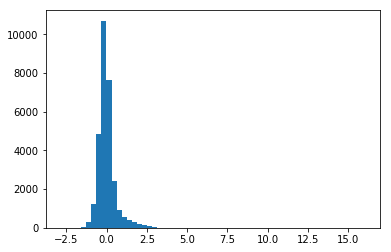

In [46]:
plt.hist(tabix_df.CADD_RAW, bins=60);
plt.show()

In [ ]:
# apply logit transformation i.e logodds, spearman correlation
ln of p/(1-p)

In [45]:
print(tabix_df.CADD_RAW.describe())
tabix_df.shape[0]/3

count    30000.000000
mean         0.034819
std          0.670035
min         -2.837239
25%         -0.278502
50%         -0.062474
75%          0.177309
max         16.052379
Name: CADD_RAW, dtype: float64


10000.0

In [41]:
desired = pd.read_csv(regions_txt, sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT'])
desired.head()

,CHROM,POS,REF,ALT
0,1,1194852,G,A
1,1,1305423,T,C
2,1,1731300,A,C
3,1,1755811,N,N
4,1,2175480,C,T


In [60]:
found_vars = pd.merge(desired, tabix_df, how='inner', on=['CHROM', 'POS', 'REF', 'ALT'])
print(found_vars.shape)

(4427, 6)


In [48]:
found_var_ids = [variant_id_string(r.CHROM, r.POS, r.REF, r.ALT) for r in found_vars.itertuples()]

In [58]:
found_var_nums = []
for found_var in tqdm(found_var_ids):
    for var_num, var_id in shuff_10k.items():
        if var_id == found_var:
            found_var_nums.append(var_num)

100%|██████████| 4427/4427 [00:14<00:00, 307.79it/s]


In [67]:
pro_training_dir = "/s/project/kipoi-cadd/data/processed/v1.3/training_data/"
found_var_ids = pro_training_dir + "found_var_ids.pkl"
dump_to_pickle(found_var_ids, shuff_10k.loc[found_var_nums])

In [68]:
ds_found = CaddDataset(lmdb_dir, found_var_ids)
X_found, y_found = ds_found.load_all(shuffle=False)
# Do the same process as the trainer
X_sparse_found = csr_matrix(X_found, shape=None, dtype=np.float32, copy=True)
X_found = X_sparse_found
y_found = y_found.astype(np.float32)
del X_sparse_found

Obtain log odd ratios:
https://stats.idre.ucla.edu/stata/faq/how-do-i-interpret-odds-ratios-in-logistic-regression/

In [95]:
y_pred_kipoi_found = clf.predict_proba(X_found)
y_pred_kipoi_found = np.array([log(p[1]/p[0]) for p in y_pred_kipoi_found])

### b. 1. Calculate Pearson Correlation between my scores and theirs

In [100]:
from scipy.stats import pearsonr
pearsonr(y_pred_kipoi_found, found_vars.CADD_RAW)

(0.7764666974344197, 0.0)

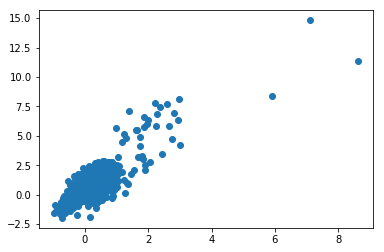

In [99]:
plt.scatter(y_pred_kipoi_found, found_vars.CADD_RAW);
plt.show()